# Comparison of HyAsP, plasmidSPAdes, MOB-recon and Recycler
    
Evalutes the predictions of the tools in terms of precision, recall and F1 score.
The three metrics are computed in two versions.

**union**: Considers all matches.   
The recall of a reference plasmids is the proportion of it covered when considering the BLAST hits of all predicted plasmids with this reference plasmid.   
Similarly, the precision of a predicted plasmid is the proportion of it covered when considering its BLAST hits with all reference plasmids.   
*To assess the capability of the tools to extract sequences of plasmid origin from the assembly.*

**best**: Considers only the best, i.e. largest, match.   
The recall of a reference plasmids is the proportion of it covered when considering only the BLAST hits of the predicted plasmid whose BLAST hits have the largest cover of this reference plasmid.   
Similarly, the precision of a predicted plasmid is the proportion of it covered when considering its BLAST hits with the reference plasmid that has the largest cover of this predicted plasmid.   
*To assess the capability of the tools to group contigs of plasmid origin into proper bins corresponding to single plasmids.*

Then, the F1 score of the respective version uses the precision and recall values of the that version.

Uses the filtered NCBI-database (only genes of length at least 100 nt from plasmids of length at least 500 nt) for HyAsP and MOB-recon.   
plasmidSPAdes and Recycler are reference-free approaches.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from Bio import SeqIO

pd.options.display.max_rows = None

In [3]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}, data_types = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h, dtype = data_types)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df       

def analyse(run, samples, hq_threshold):
    df_references = []
    df_predictions = []
    df_pairs = []

    for sample_id in samples:
        # evaluation files
        files = dict()
        files['HyAsP'] = '%s/sample_%i/eval/greedy/greedy_eval.csv' % (run, sample_id)
        files['MOB-recon'] = '%s/sample_%i/eval/mob_recon/mob_recon_eval.csv' % (run, sample_id)
        files['plasmidSPAdes'] = '%s/sample_%i/eval/plasmidspades/plasmidspades_eval.csv' % (run, sample_id)
        files['Recycler'] = '/project/6007976/wg-anoph/Plasmids-Assembly/revision1/recycler_test/recycler_outputs/eval/%i_recycler_eval.csv' % sample_id

        # reference information
        _, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(files['HyAsP'])
        num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

        ref_plasmids = list_plasmids(files['HyAsP'], skip_ref_plasmids, num_ref_plasmids)
        ref_plasmids.set_index('plasmid', inplace = True)

        for tool in files:
            if os.path.isfile(files[tool]): 
                _, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores = parse_structure(files[tool])
                num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2

                best_recall = read_table(files[tool], skip_ref_by_pred, num_pred_plasmids, data_types = {'Unnamed: 0': str})
                best_recall = best_recall.loc[:, best_recall.columns != 'Unnamed: 0'].max().to_frame()
                best_recall.columns = ['proportion']

                union_recall = read_table(files[tool], skip_ref_by_all, num_ref_plasmids, data_types = {'plasmid': str, 'proportion': float})
                union_recall.set_index('plasmid', inplace = True)

                for pla, row in ref_plasmids.iterrows():
                    if num_pred_plasmids > 0:
                        df_references.append([tool, sample_id, pla, row['length (nt)'], best_recall.at[pla, 'proportion'], union_recall.at[pla, 'proportion']])
                    else:
                        df_references.append([tool, sample_id, pla, row['length (nt)'], 0, 0])


                if num_pred_plasmids > 0:
                    pred_plasmids = list_plasmids(files[tool], skip_pred_plasmids, num_pred_plasmids)
                    pred_plasmids.set_index('plasmid', inplace = True)

                    best_precision = read_table(files[tool], skip_pred_by_ref, num_ref_plasmids, data_types = {'Unnamed: 0': str})
                    best_precision = best_precision.loc[:, best_precision.columns != 'Unnamed: 0'].max().to_frame()
                    best_precision.columns = ['proportion']

                    union_precision = read_table(files[tool], skip_pred_by_all, num_pred_plasmids, data_types = {'plasmid': str, 'proportion': float})
                    union_precision['plasmid'] = union_precision['plasmid'].astype(str)
                    union_precision.set_index('plasmid', inplace = True)

                    for pla, row in pred_plasmids.iterrows():
                        df_predictions.append([tool, sample_id, pla, row['length (nt)'], best_precision.at[pla, 'proportion'], union_precision.at[pla, 'proportion']])
                        
                    
                num_pairs = skip_summary_scores - skip_mutual - 2
                pairs = read_table(files[tool], skip_mutual, num_pairs, s = ' ', h = None).astype(str)
                if len(pairs.columns) > 1:
                    pairs.drop(columns = [1, 4], inplace = True)
                    pairs.columns = ['reference', 'prediction', 'recall', 'precision']
                    pairs['recall'] = [float(val[1:]) for val in pairs['recall']]
                    pairs['precision'] = [float(val[:-1]) for val in pairs['precision']]

                    for i, row in pairs.iterrows():
                        if row['recall'] >= hq_threshold and row['precision'] >= hq_threshold:
                            df_pairs.append([tool, sample_id, row['reference'], row['prediction'], row['recall'], row['precision']])

            else:
                for pla, row in ref_plasmids.iterrows():
                    df_references.append([tool, sample_id, pla, row['length (nt)'], 0, 0])
                    
    df_references = pd.DataFrame(df_references, columns = ['tool', 'sample_id', 'plasmid_id', 'length', 'best_recall', 'union_recall'])
    df_predictions = pd.DataFrame(df_predictions, columns = ['tool', 'sample_id', 'plasmid_id', 'length', 'best_precision', 'union_precision'])
    df_pairs = pd.DataFrame(df_pairs, columns = ['tool', 'sample_id', 'reference', 'prediction', 'recall', 'precision'])

    return df_references, df_predictions, df_pairs

def aggregate(df_references, df_predictions):
    contents = []

    for m in ['HyAsP', 'MOB-recon', 'plasmidSPAdes', 'Recycler']:
        t = df_references.loc[df_references['tool'] == m]
        agg_recall_union = 0
        agg_recall_best = 0
        len_sum_refs = 0
        for i, row in t.iterrows():
            agg_recall_union += row['length'] * row['union_recall']
            agg_recall_best += row['length'] * row['best_recall']
            len_sum_refs += row['length']

        t = df_predictions.loc[df_predictions['tool'] == m]
        agg_precision_union = 0
        agg_precision_best = 0
        len_sum_preds = 0
        for i, row in t.iterrows():
            agg_precision_union += row['length'] * row['union_precision']
            agg_precision_best += row['length'] * row['best_precision']
            len_sum_preds += row['length']

        recall_union = agg_recall_union / len_sum_refs
        recall_best = agg_recall_best / len_sum_refs

        precision_union = agg_precision_union / len_sum_preds
        precision_best = agg_precision_best / len_sum_preds

        f1_union = 2 * precision_union * recall_union / (precision_union + recall_union)
        f1_best = 2 * precision_best * recall_best / (precision_best + recall_best)

        contents.append([m, 'union', precision_union, recall_union, f1_union])
        contents.append([m, 'best', precision_best, recall_best, f1_best])

    return pd.DataFrame(contents, columns = ['tool', 'evaluation', 'precision', 'recall', 'f1'])

In [4]:
run = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_ncbi_filtered'
samples = [1, 5, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44] \
        + [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 62, 63, 64, 65, 66, 76, 85, 86, 87, 102, 107, 108, 109, 110] \
        + [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 129, 133]
threshold = 0.9

sample_info = pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-05-23__MOB-suite_benchmark_reads/samples.csv', sep = ';')
sample_info['Organism'] = [' '.join(org.split(' ')[:2]) for org in sample_info.Organism]
test_samples = sample_info.loc[sample_info['SampleId'].isin(samples)]
    
samples_per_org = dict()
for name, grp in test_samples.groupby(['Organism']):
    samples_per_org[name] = list(grp['SampleId'])

ncbi_references, ncbi_predictions, ncbi_pairs = analyse(run, samples, threshold)

**Aggregated scores over all test samples**

In [5]:
aggregate(ncbi_references, ncbi_predictions)

,tool,evaluation,precision,recall,f1
0,HyAsP,union,0.871447,0.898824,0.884924
1,HyAsP,best,0.825117,0.621696,0.709106
2,MOB-recon,union,0.760242,0.583911,0.660511
3,MOB-recon,best,0.756172,0.476373,0.584514
4,plasmidSPAdes,union,0.659212,0.741985,0.698154
5,plasmidSPAdes,best,0.560784,0.736594,0.636777
6,Recycler,union,0.349300,0.103779,0.160017
7,Recycler,best,0.349300,0.103061,0.159162


**Precision**: almost no difference for MOB-recon; HyAsP still highest   
**Recall**: almost no difference for plasmidSPAdes; HyAsP still better than MOB-recon but worse than plasmidSPAdes   
**F1 score**: best notably lower for all tools; largest difference for HyAsP but still highest

### Precision, recall and F1 score per sample

Refinements: species information, both best and union scores

In [6]:
contents = []
for key, grp in ncbi_references.groupby(['tool', 'sample_id']):
    tool = key[0]
    sid = key[1]
    
    recalled_nt_best = 0
    recalled_nt_union = 0
    total_length_refs = 0
    for i, row in grp.iterrows():
        recalled_nt_best += row['length'] * row['best_recall']
        recalled_nt_union += row['length'] * row['union_recall']
        total_length_refs += row['length']
    recall_best = recalled_nt_best / total_length_refs
    recall_union = recalled_nt_union / total_length_refs
    
    predictions = ncbi_predictions.loc[ncbi_predictions['tool'] == tool].loc[ncbi_predictions['sample_id'] == sid]
    precise_nt_best = 0
    precise_nt_union = 0
    total_length_preds = 0
    for i, row in predictions.iterrows():
        precise_nt_best += row['length'] * row['best_precision']
        precise_nt_union += row['length'] * row['union_precision']
        total_length_preds += row['length']
    precision_best = precise_nt_best / total_length_preds if total_length_preds > 0 else 0.0
    precision_union = precise_nt_union / total_length_preds if total_length_preds > 0 else 0.0
    
    f1_best = 2 * recall_best * precision_best / (recall_best + precision_best) if (recall_best + precision_best) > 0 else 0.0
    f1_union = 2 * recall_union * precision_union / (recall_union + precision_union) if (recall_union + precision_union) > 0 else 0.0

    contents.append([tool, sid, recall_best, recall_union, precision_best, precision_union, f1_best, f1_union])

scores_per_sample = pd.DataFrame(contents, columns = ['tool', 'sample_id', 'Recall (best)', 'Recall (union)', 'Precision (best)', 'Precision (union)', 'F1 score (best)', 'F1 score (union)'])

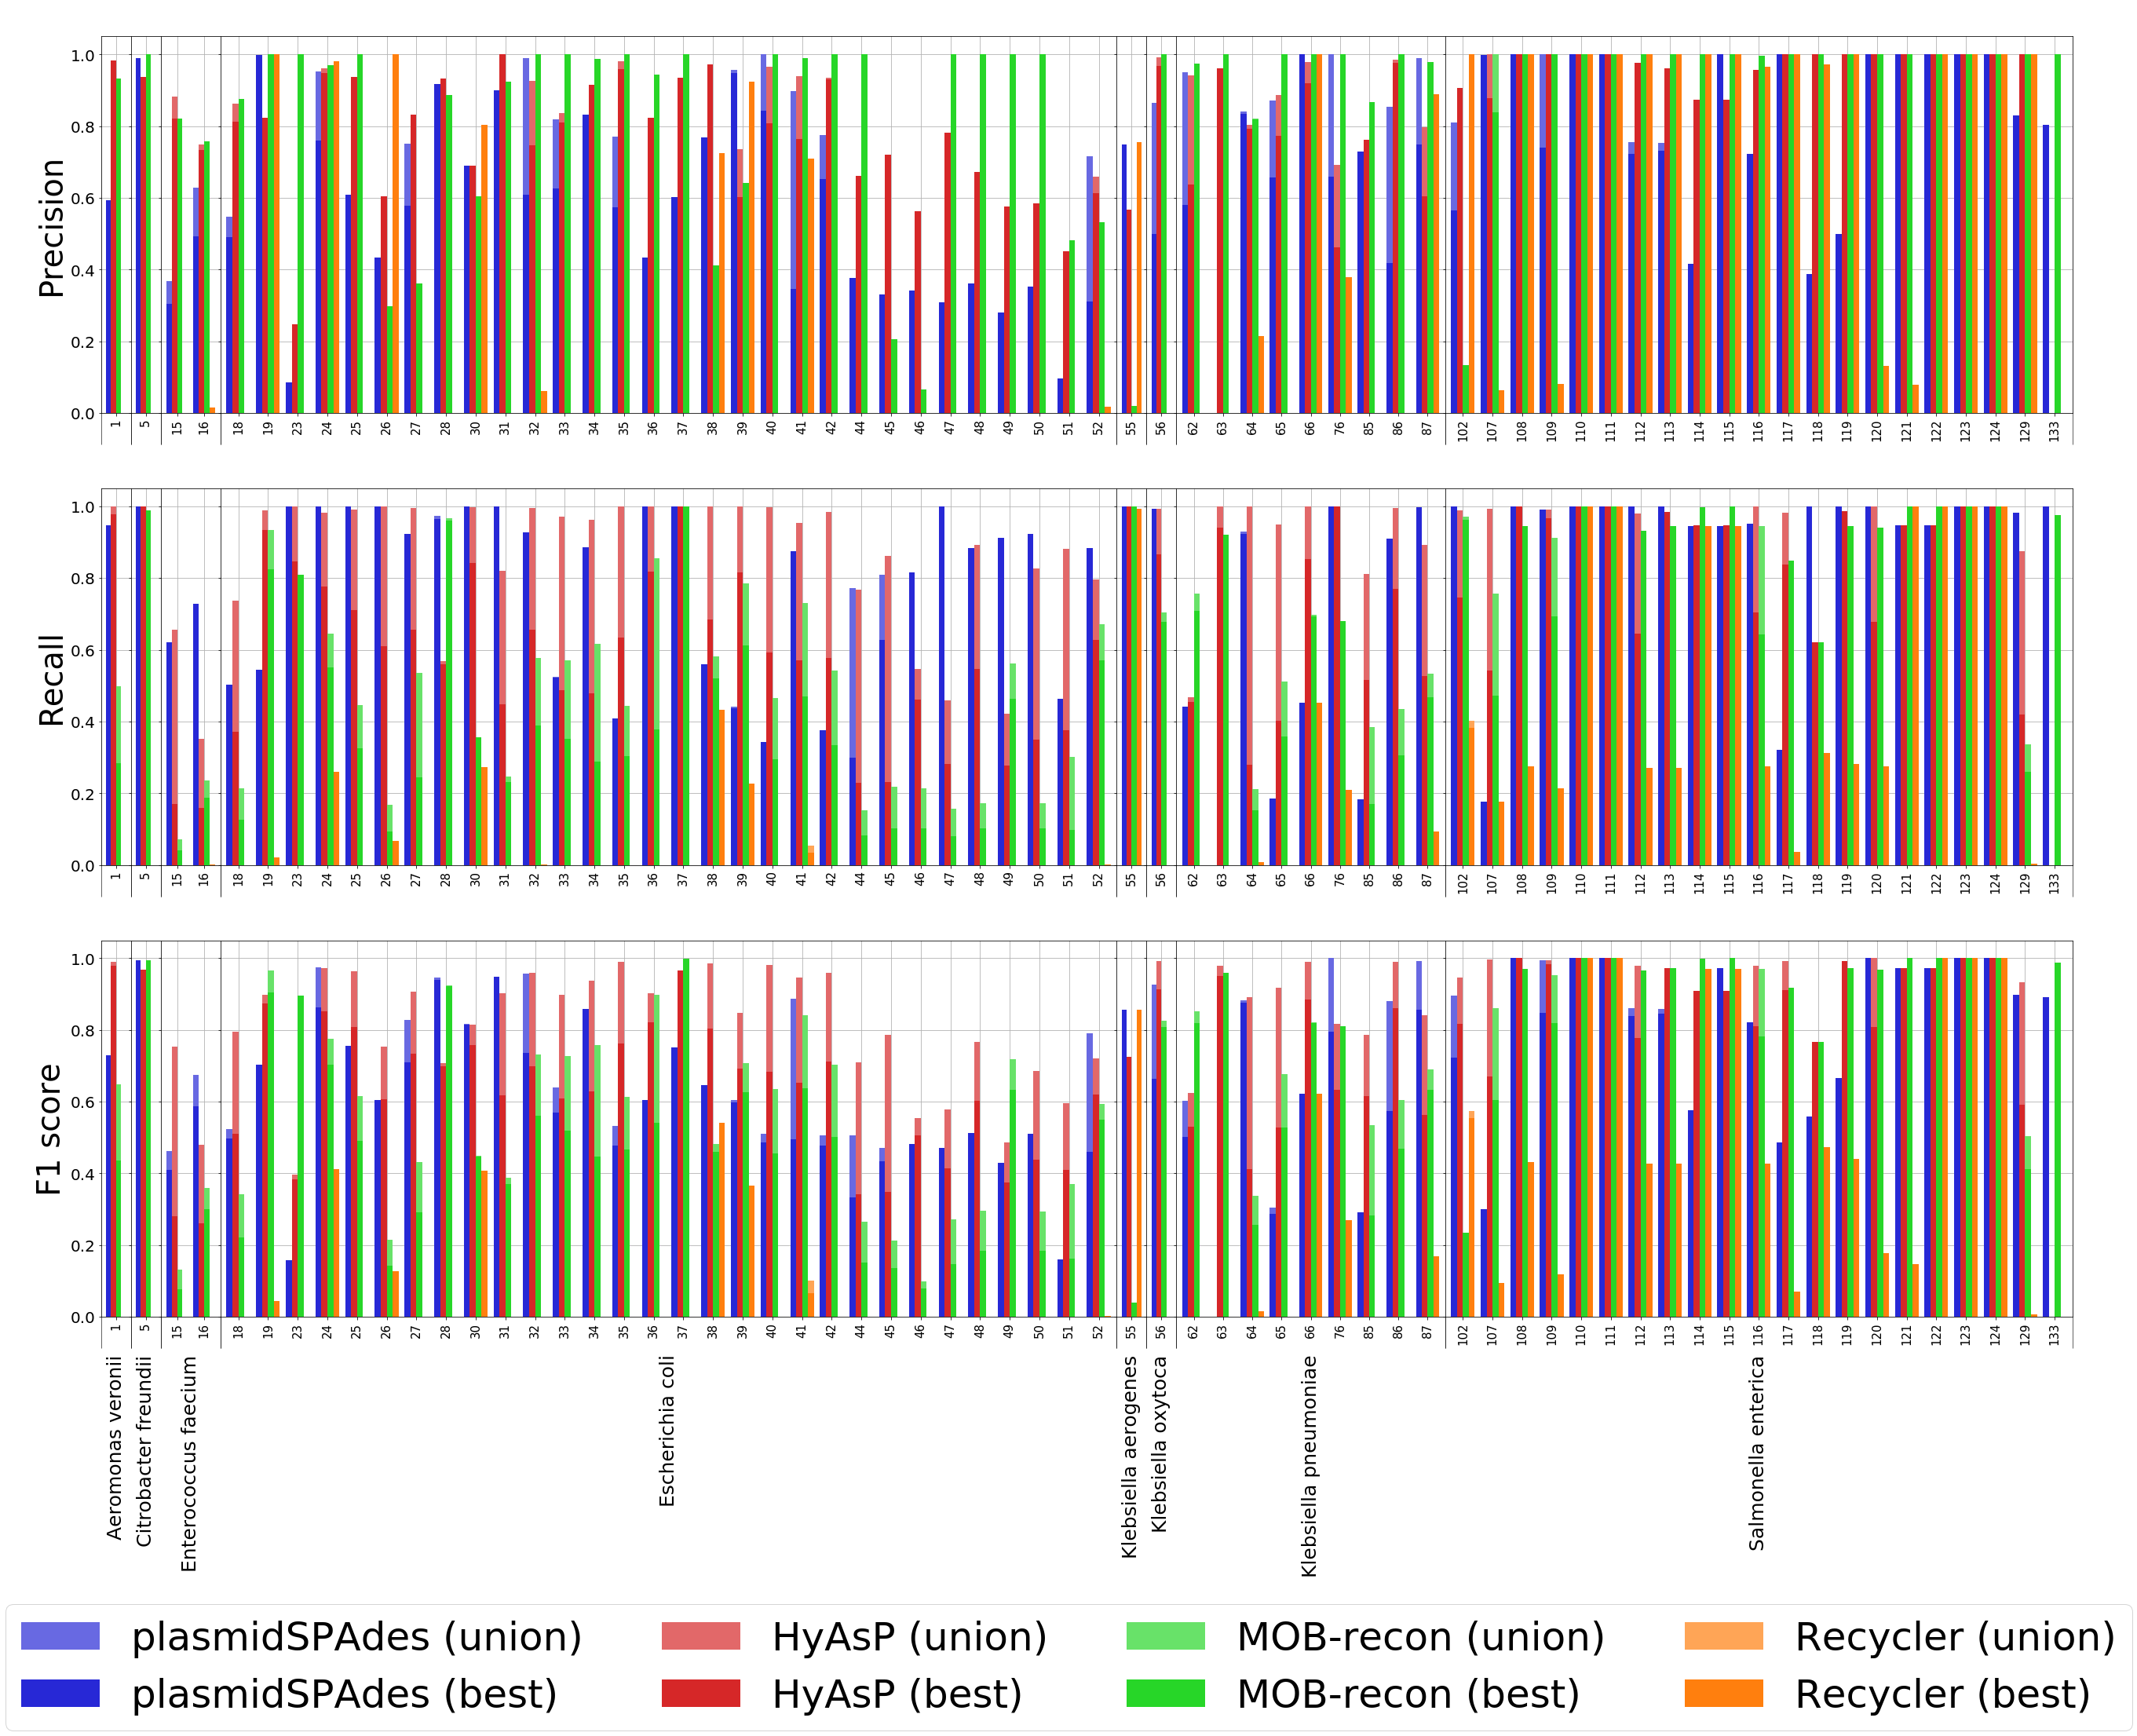

In [7]:
def plot_scores_per_sample(full_df, organism_grps, fs = (45, 30)):    
    tools = ['plasmidSPAdes', 'HyAsP', 'MOB-recon', 'Recycler']
    score_labels = ['Precision', 'Recall', 'F1 score']
    # with transparency (alpha = 0.7)
    #alpha = 0.7
    #colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e']
    # without transparency
    alpha = 1.0
    colours = ['#6869e2', '#e26869', '#68e269', '#ffa556', '#2728d6', '#d62728', '#27d628', '#ff7f0e']
    
    organisms = sorted(organism_grps.keys())
    
    fig, axes = plt.subplots(nrows = len(score_labels), ncols = len(organisms), figsize = fs, sharey = True, 
                             gridspec_kw = {'width_ratios' : [len(organism_grps[g]) for g in organisms]})
    
    
    for j, org in enumerate(organisms):
        df = full_df.loc[full_df['sample_id'].isin(organism_grps[org])]
        num_samples = len(df['sample_id'].unique())
        pos = list(range(num_samples))

        for i, lab in enumerate(score_labels):
            width = 1 / (len(df['tool'].unique()) + 1)
            offset = -len(df['tool'].unique()) / 2
            
            for k, tool in enumerate(tools):
                positions = [p + offset * width for p in pos]
                axes[i][j].bar(positions, df['%s (union)' % lab][df['tool'] == tool], width = width, zorder = 3, 
                               color = colours[k], alpha = alpha, label = '%s (union)' % tool)
                axes[i][j].bar(positions, df['%s (best)' % lab][df['tool'] == tool], width = width, zorder = 3,
                               color = colours[k + len(tools)], alpha = alpha, label = '%s (best)' % tool)
                
                offset += 1
                
            axes[i][j].grid(True, zorder = 0)
            axes[i][j].set_xlim(min(pos) - 0.5 * width - width * (len(tools) - 1), max(pos) - 0.5 * width + width * (len(tools) - 1))
            axes[i][j].set_xticks([p - 0.5 * width for p in pos], minor = False)
            axes[i][j].set_xticks([min(pos) - 0.5 * width - width * (len(tools) - 1), max(pos) - 0.5 * width + width * (len(tools) - 1)], minor = True)
            axes[i][j].tick_params(which = 'minor', length = 40)
            axes[i][j].set_xticklabels(df['sample_id'].unique(), rotation = 90, fontsize = 15)

    for i in range(0, len(score_labels)):
        axes[i][0].set_ylabel(score_labels[i], fontsize = 40)
        axes[i][0].yaxis.set_tick_params(labelsize = 20)
    for j, org in enumerate(organisms):
        axes[-1][j].set_xlabel(org, rotation = 90, fontsize = 25)

    plt.legend(fontsize = 50, markerscale = 3, ncol = len(tools), loc = 'lower center', bbox_to_anchor = (-0.6, -1.15))

    plt.subplots_adjust(wspace = 0)
    
    plt.savefig('per_sample_ncbi_filtered.eps', format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('per_sample_ncbi_filtered.pdf', format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('per_sample_ncbi_filtered.png', format = 'png', dpi = 1200, bbox_inches = 'tight')
    
plot_scores_per_sample(scores_per_sample, samples_per_org)

### Differences in precision, recall and F1 score per sample

Refinements: species information, both best and union scores

In [8]:
contents = []
for sid, grp in scores_per_sample.groupby(['sample_id']):
    hyasp_best_precision = grp.loc[grp['tool'] == 'HyAsP', 'Precision (best)'].item()
    hyasp_best_recall = grp.loc[grp['tool'] == 'HyAsP', 'Recall (best)'].item()
    hyasp_best_f1 = grp.loc[grp['tool'] == 'HyAsP', 'F1 score (best)'].item()
    hyasp_union_precision = grp.loc[grp['tool'] == 'HyAsP', 'Precision (union)'].item()
    hyasp_union_recall = grp.loc[grp['tool'] == 'HyAsP', 'Recall (union)'].item()
    hyasp_union_f1 = grp.loc[grp['tool'] == 'HyAsP', 'F1 score (union)'].item()
    
    for other in ['plasmidSPAdes', 'MOB-recon', 'Recycler']:
        contents.append([other, sid,
                        grp.loc[grp['tool'] == other, 'Recall (best)'].item() - hyasp_best_recall,
                        grp.loc[grp['tool'] == other, 'Recall (union)'].item() - hyasp_union_recall,
                        grp.loc[grp['tool'] == other, 'Precision (union)'].item() - hyasp_union_precision,
                        grp.loc[grp['tool'] == other, 'Precision (best)'].item() - hyasp_best_precision,
                        grp.loc[grp['tool'] == other, 'F1 score (best)'].item() - hyasp_best_f1,
                        grp.loc[grp['tool'] == other, 'F1 score (union)'].item() - hyasp_union_f1])

scores_diffs = pd.DataFrame(contents, columns = ['tool', 'sample_id', 'Recall (best)', 'Recall (union)', 'Precision (best)', 'Precision (union)', 'F1 score (best)', 'F1 score (union)'])

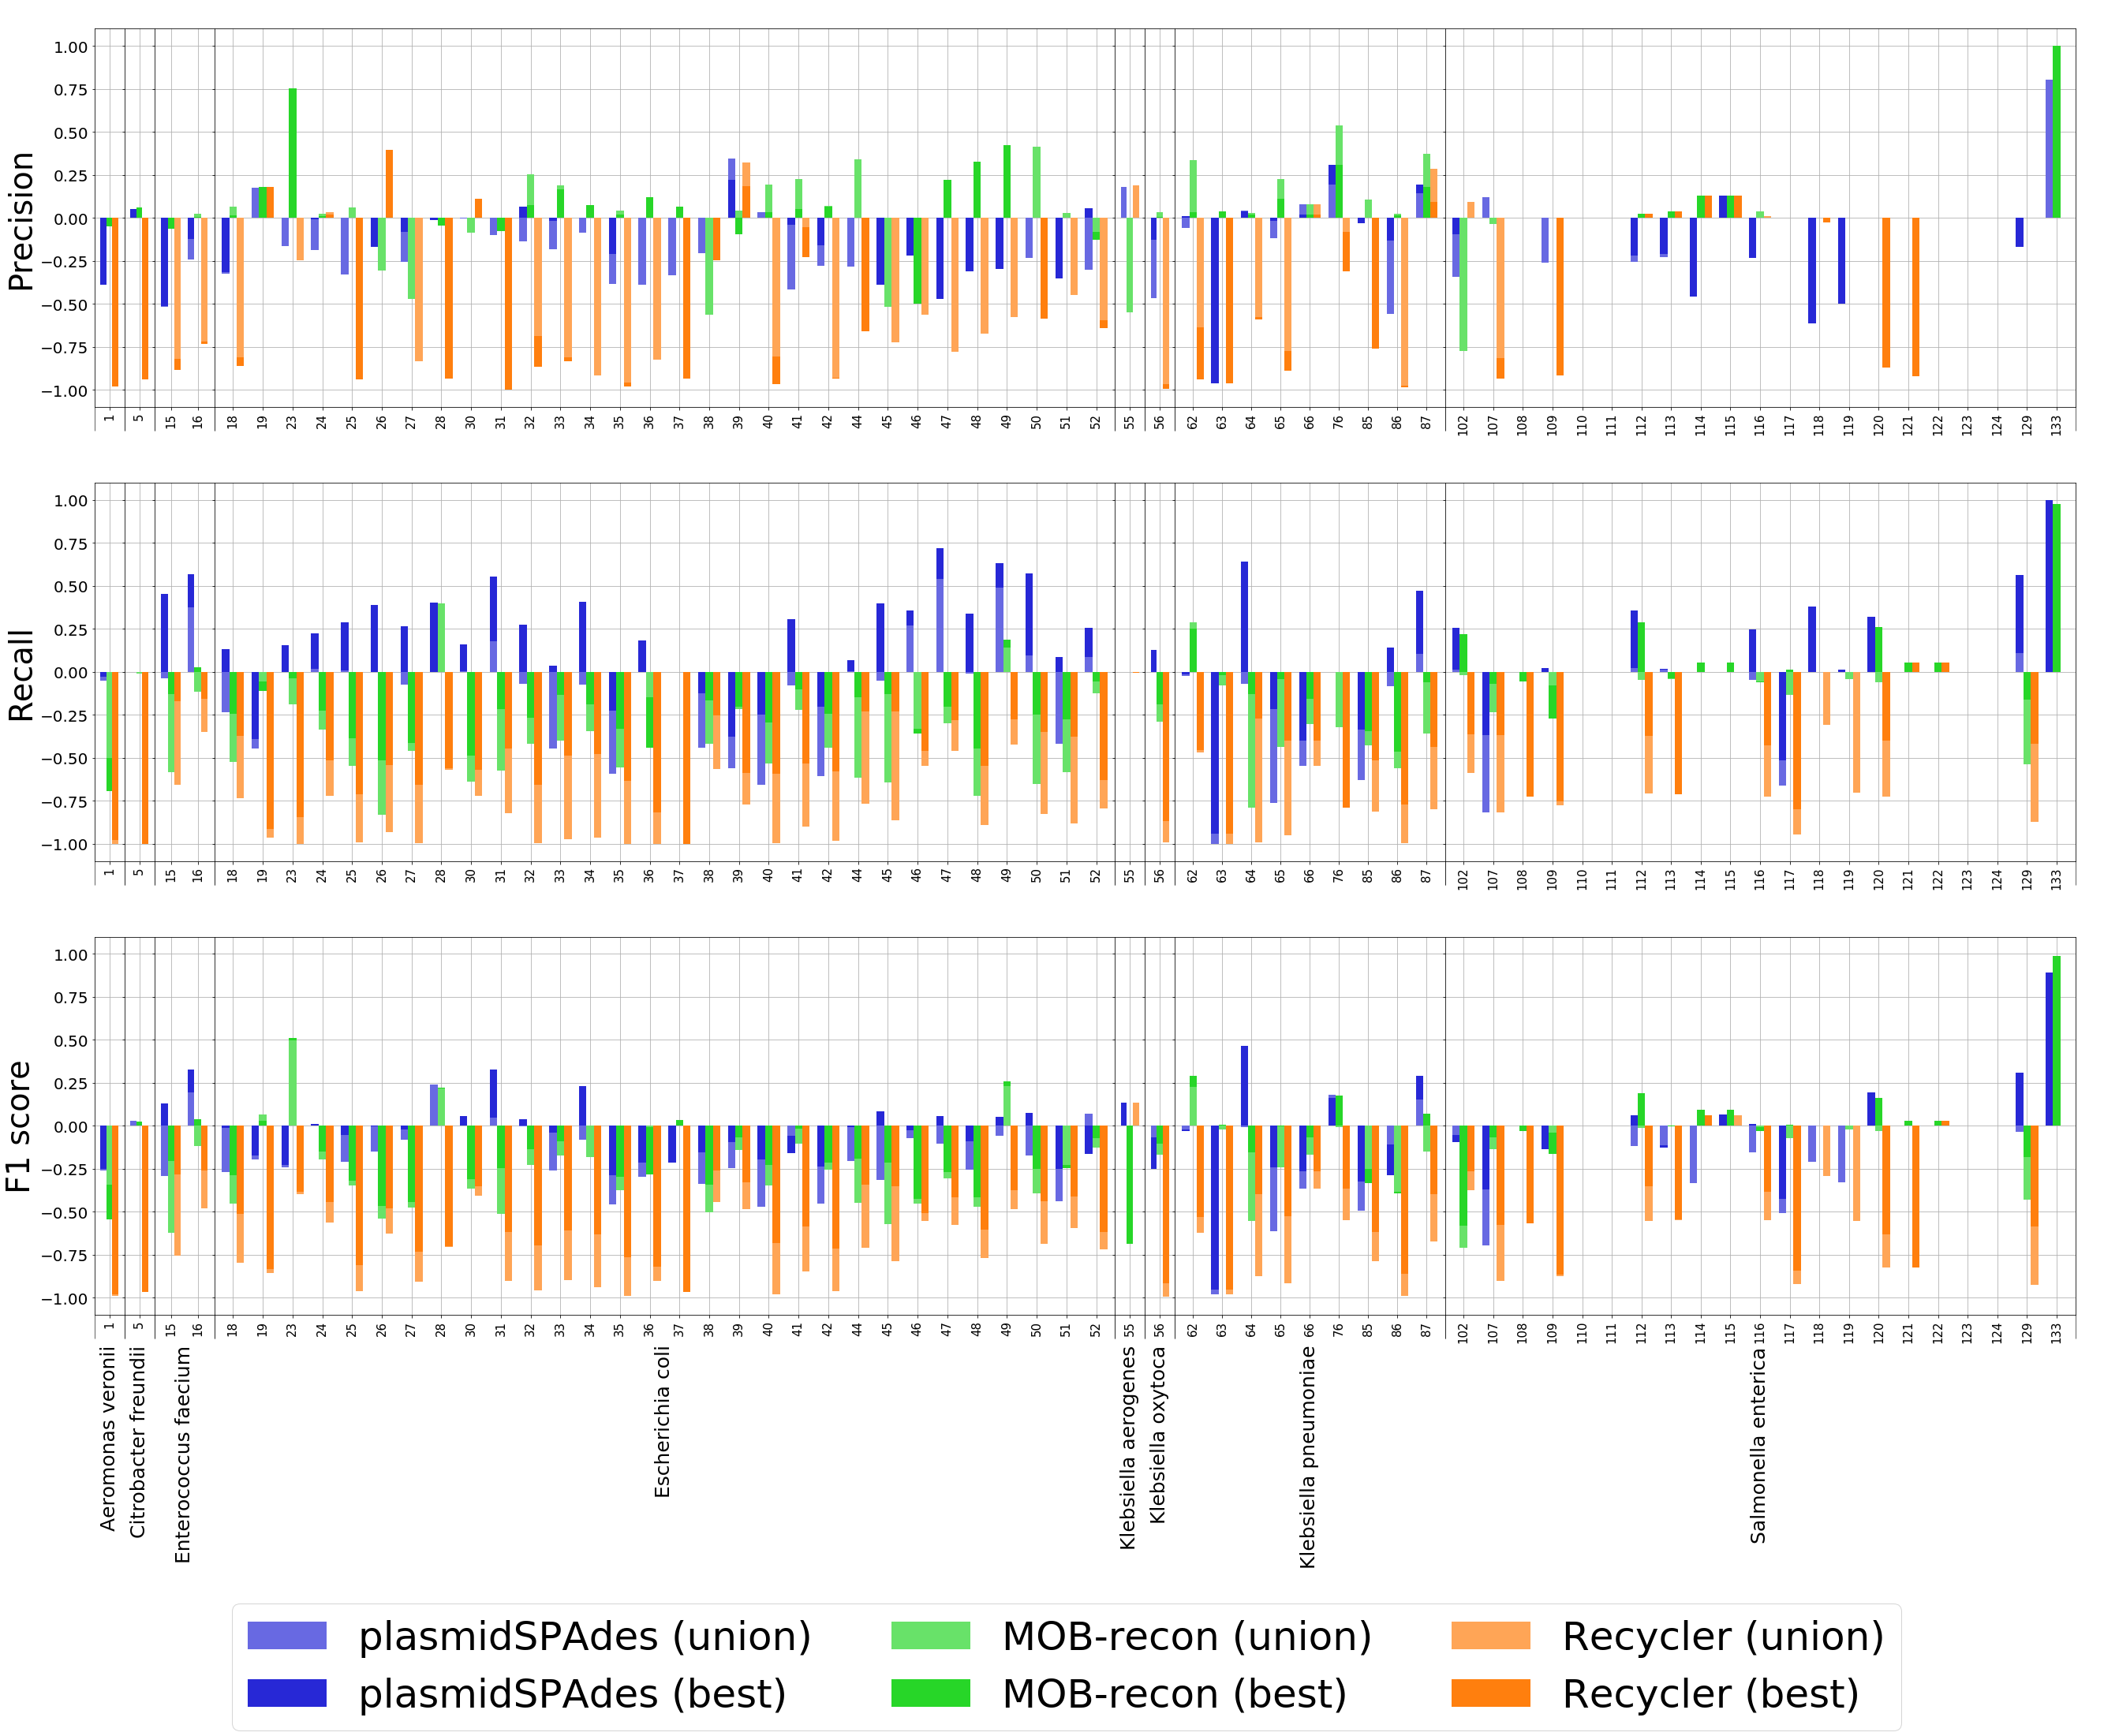

In [9]:
def plot_score_differences_per_sample(full_df, organism_grps, fs = (45, 30)):
    tools = ['plasmidSPAdes', 'MOB-recon', 'Recycler']
    score_labels = ['Precision', 'Recall', 'F1 score']
    # with transparency (alpha = 0.7)
    #alpha = 0.7
    #colours = ['#2728d6', '#27d628', '#ff7f0e']
    # without transparency
    alpha = 1.0
    colours = ['#6869e2', '#68e269', '#ffa556', '#2728d6', '#27d628', '#ff7f0e']
    
    organisms = sorted(organism_grps.keys())

    fig, axes = plt.subplots(nrows = len(score_labels), ncols = len(organisms), figsize = fs, sharey = True, 
                             gridspec_kw = {'width_ratios' : [len(organism_grps[g]) for g in organisms]})
    
    for j, org in enumerate(organisms):
        df = full_df.loc[full_df['sample_id'].isin(organism_grps[org])]
        num_samples = len(df['sample_id'].unique())
        pos = list(range(num_samples))
        
        for i, lab in enumerate(score_labels):
            width = 1 / (len(df['tool'].unique()) + 1)
            offset = -len(df['tool'].unique()) / 2

            for k, tool in enumerate(df['tool'].unique()):
                positions = [p + offset * width for p in pos]
                union_values = df['%s (union)' % lab][df['tool'] == tool].copy()
                best_values = df['%s (best)' % lab][df['tool'] == tool].copy()
                
                # union larger
                values = union_values.copy()
                to_zero = abs(union_values) < abs(best_values)
                values[to_zero] = [0] * sum(to_zero)
                axes[i][j].bar(positions, values, width = width, zorder = 3, 
                               color = colours[k], alpha = alpha, label = '%s (union)' % tool)
                values = best_values.copy()
                values[to_zero] = [0] * sum(to_zero)
                axes[i][j].bar(positions, values, width = width, zorder = 3, 
                               color = colours[k + len(tools)], alpha = alpha, label = '%s (best)' % tool)
                
                # best larger
                values = best_values.copy()
                to_zero = abs(union_values) >= abs(best_values)
                values[to_zero] = [0] * sum(to_zero)
                axes[i][j].bar(positions, values, width = width, zorder = 3, 
                               color = colours[k + len(tools)], alpha = alpha)#, label = '%s (best)' % tool)
                values = union_values.copy()
                values[to_zero] = [0] * sum(to_zero)
                axes[i][j].bar(positions, values, width = width, zorder = 3, 
                               color = colours[k], alpha = alpha)#, label = '%s (union)' % tool)

                offset += 1

            axes[i][j].grid(True, zorder = 0)
            axes[i][j].set_xlim(min(positions) - 0.5 * width - width * (len(tools) - 0), max(positions) - 0.5 * width + width * (len(tools) - 1))
            axes[i][j].set_xticks([p - 0.5 * width for p in pos], minor = False)
            axes[i][j].set_xticks([min(positions) - 0.5 * width - width * (len(tools) - 0), max(positions) - 0.5 * width + width * (len(tools) - 1)], minor = True)
            axes[i][j].tick_params(which = 'minor', length = 30)
            axes[i][j].set_xticklabels(df['sample_id'].unique(), rotation = 90, fontsize = 15)
            
    for i in range(0, len(score_labels)):
        axes[i][0].set_ylabel(score_labels[i], fontsize = 40)
        axes[i][0].yaxis.set_tick_params(labelsize = 20)
    for j, org in enumerate(organisms):
        axes[-1][j].set_xlabel(org, rotation = 90, fontsize = 25)

    plt.legend(fontsize = 50, markerscale = 3, ncol = len(tools), loc = 'lower center', bbox_to_anchor = (-0.6, -1.15))
    
    plt.subplots_adjust(wspace = 0)
    
    
    plt.savefig('differences_ncbi_filtered.eps', format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('differences_ncbi_filtered.pdf', format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('differences_ncbi_filtered.png', format = 'png', dpi = 1200, bbox_inches = 'tight')
    
plot_score_differences_per_sample(scores_diffs, samples_per_org)

### Distributions of precision, recall and F1 score

Refinement: plot for best scores and plot for union scores

In [10]:
greedy_putative_rows = scores_per_sample['tool'] == 'HyAsP'
plasmidspades_rows = scores_per_sample['tool'] == 'plasmidSPAdes'
mob_recon_rows = scores_per_sample['tool'] == 'MOB-recon'
recycler_rows = scores_per_sample['tool'] == 'Recycler'

best_precision_values = [scores_per_sample['Precision (best)'][plasmidspades_rows], scores_per_sample['Precision (best)'][greedy_putative_rows], scores_per_sample['Precision (best)'][mob_recon_rows], scores_per_sample['Precision (best)'][recycler_rows]]
best_recall_values = [scores_per_sample['Recall (best)'][plasmidspades_rows], scores_per_sample['Recall (best)'][greedy_putative_rows], scores_per_sample['Recall (best)'][mob_recon_rows], scores_per_sample['Recall (best)'][recycler_rows]]
best_f1_score_values = [scores_per_sample['F1 score (best)'][plasmidspades_rows], scores_per_sample['F1 score (best)'][greedy_putative_rows], scores_per_sample['F1 score (best)'][mob_recon_rows], scores_per_sample['F1 score (best)'][recycler_rows]]

union_precision_values = [scores_per_sample['Precision (union)'][plasmidspades_rows], scores_per_sample['Precision (union)'][greedy_putative_rows], scores_per_sample['Precision (union)'][mob_recon_rows], scores_per_sample['Precision (union)'][recycler_rows]]
union_recall_values = [scores_per_sample['Recall (union)'][plasmidspades_rows], scores_per_sample['Recall (union)'][greedy_putative_rows], scores_per_sample['Recall (union)'][mob_recon_rows], scores_per_sample['Recall (union)'][recycler_rows]]
union_f1_score_values = [scores_per_sample['F1 score (union)'][plasmidspades_rows], scores_per_sample['F1 score (union)'][greedy_putative_rows], scores_per_sample['F1 score (union)'][mob_recon_rows], scores_per_sample['F1 score (union)'][recycler_rows]]

tool_labels = ['plasmid-\nSPAdes', 'HyAsP', 'MOB-recon', 'Recycler']

# with transparency
#def create_subplot(fig, axes, c, title, data, labels, scatter_colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e'], 
#                   colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e'], alpha = 0.3):
# without transparency
def create_subplot(fig, axes, c, title, data, labels, scatter_colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e'], 
                   colours = ['#bebff3', '#f3bebf', '#bef3bf', '#ffd9b7'], alpha = 1.0):
    parts = axes[c].violinplot(data, showextrema = True, showmedians = True)
    axes[c].set_title(title, fontsize = 60)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[c].scatter(inds, data[i], color = scatter_colours[i], alpha = 1, s = 50, zorder = 3, label = labels[i])
        parts['bodies'][i].set_facecolor(colours[i])
        parts['bodies'][i].set_alpha(alpha)

**Best scores**

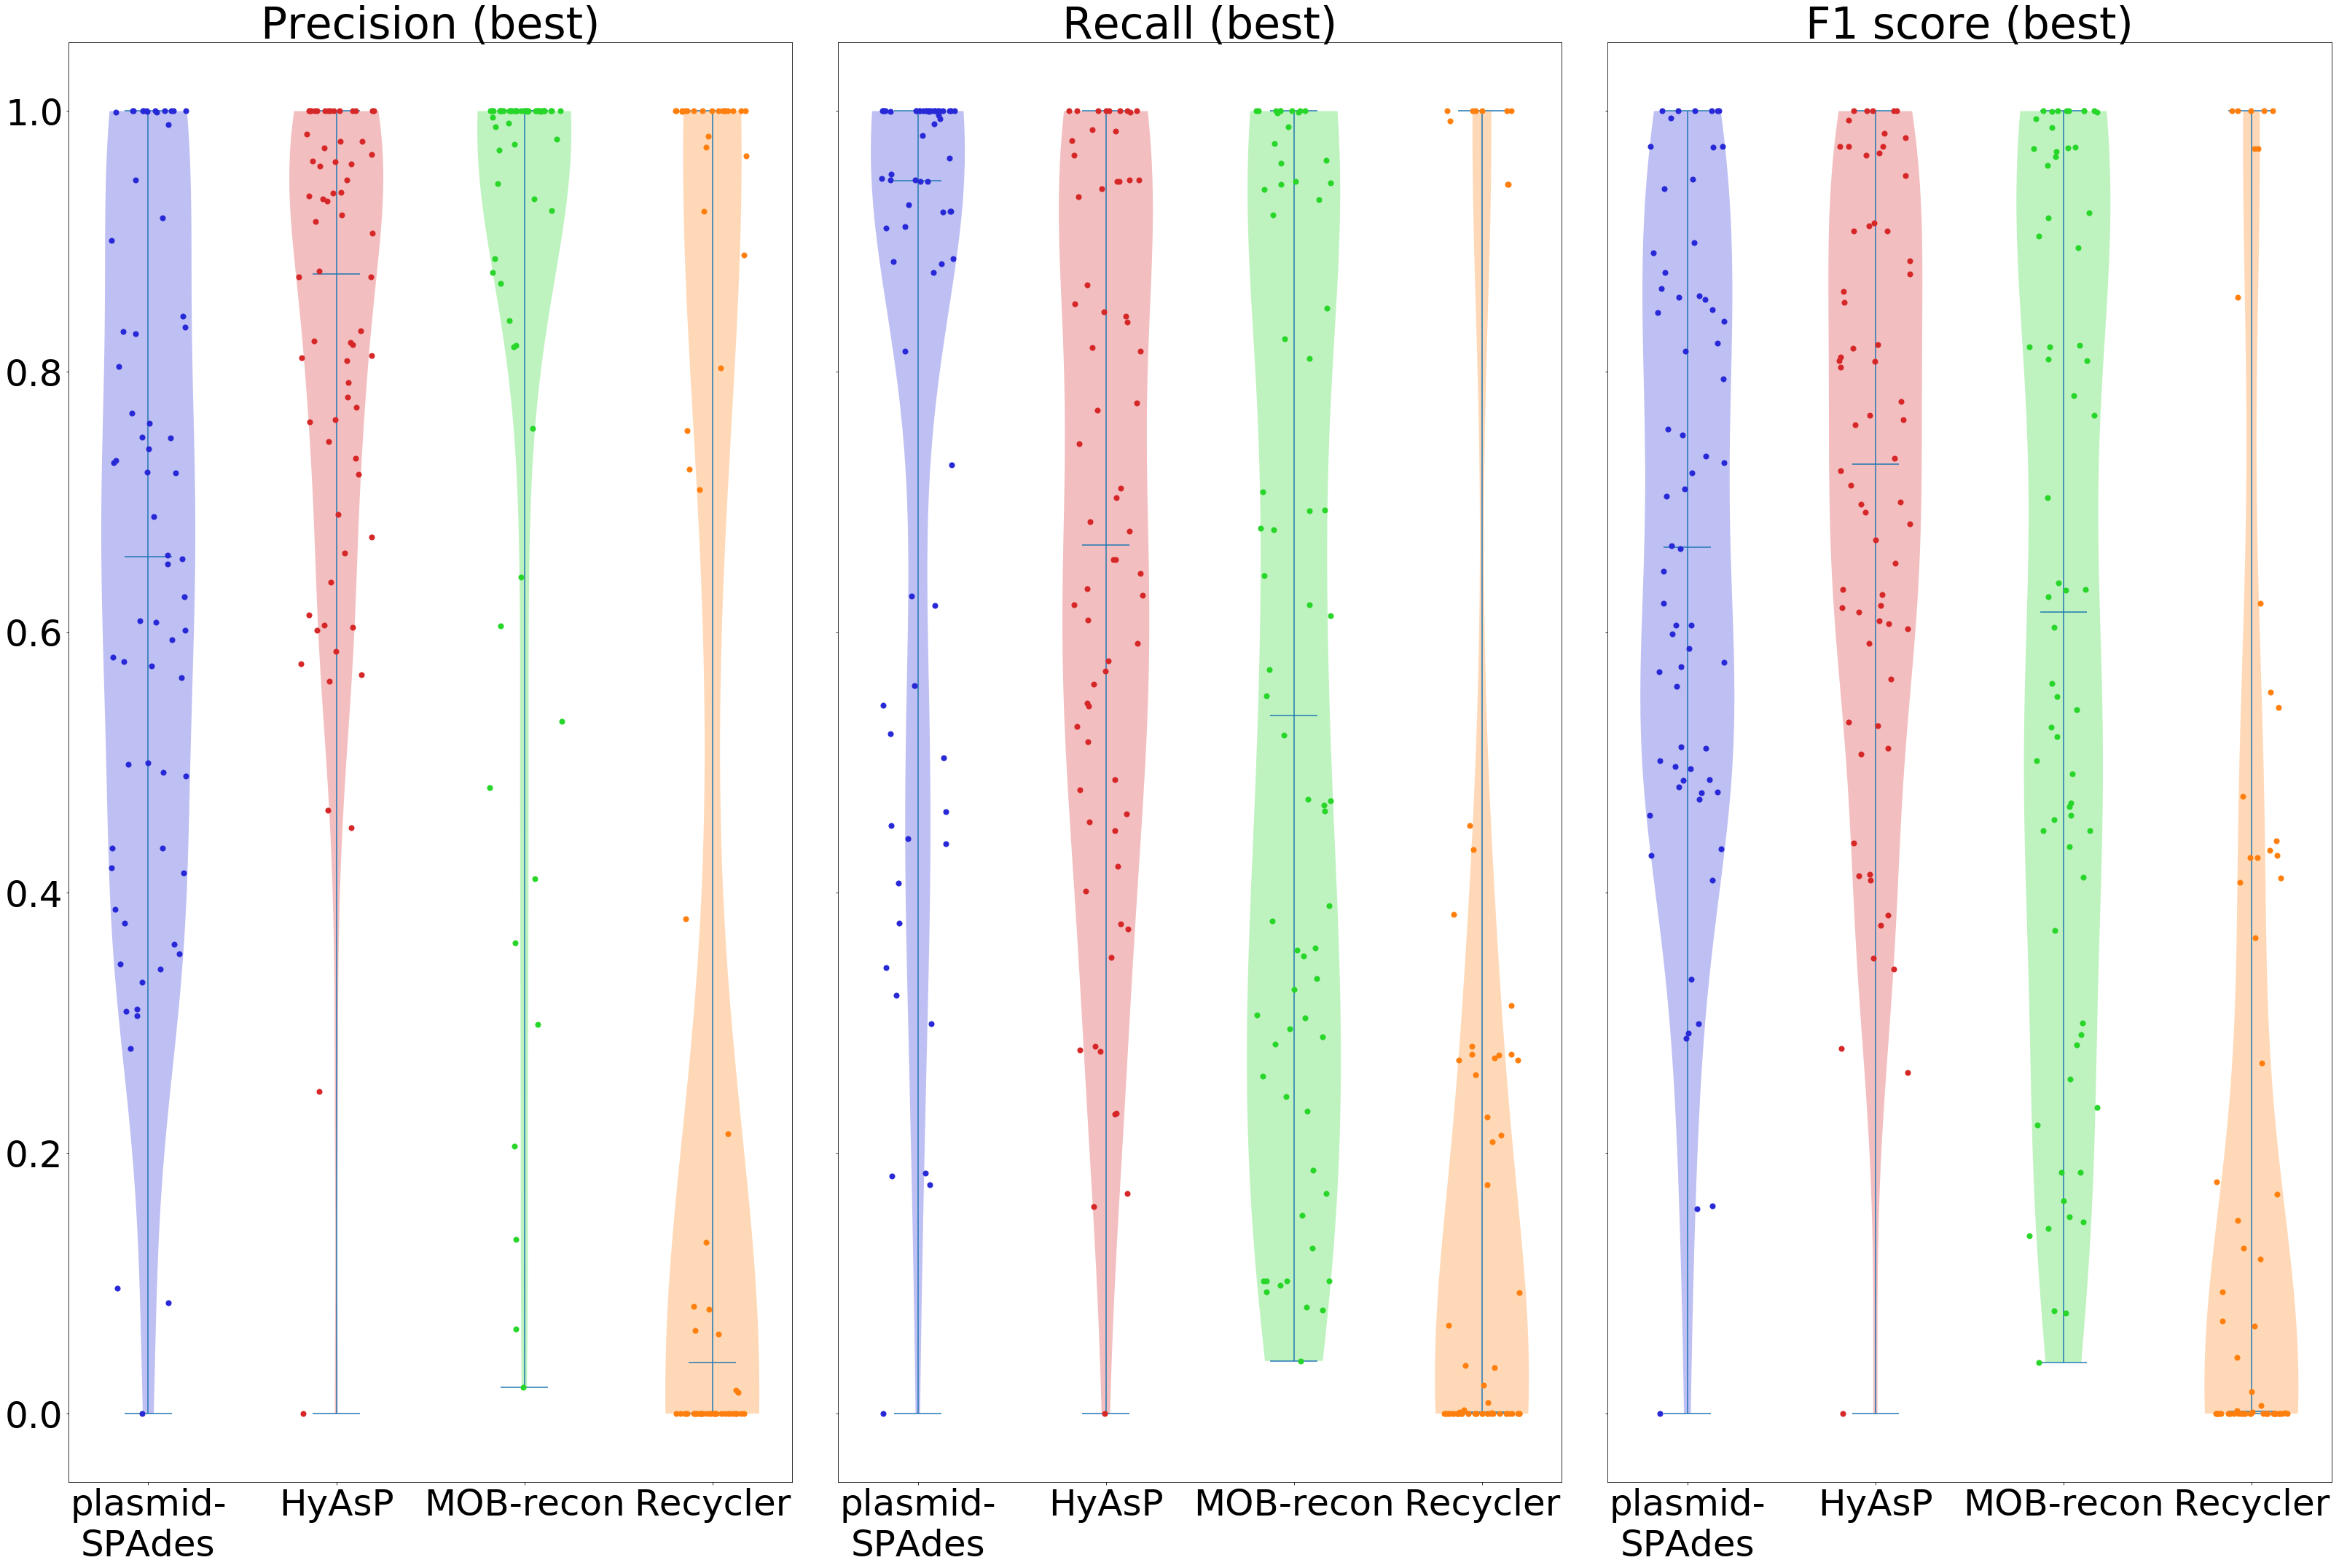

In [11]:
fig, axes = plt.subplots(ncols = 3, figsize = (45, 30), sharey = 'row')

create_subplot(fig, axes, 0, 'Precision (best)', best_precision_values, tool_labels)
create_subplot(fig, axes, 1, 'Recall (best)', best_recall_values, tool_labels)
create_subplot(fig, axes, 2, 'F1 score (best)', best_f1_score_values, tool_labels)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelsize = 50)
    ax.xaxis.set_tick_params(labelsize = 50)
    labels = tool_labels
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(labels)
plt.tight_layout()

plt.savefig('distributions_ncbi_filtered_best.eps', format = 'eps', dpi = 1200)
plt.savefig('distributions_ncbi_filtered_best.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('distributions_ncbi_filtered_best.png', format = 'png', dpi = 1200)

**Union scores**

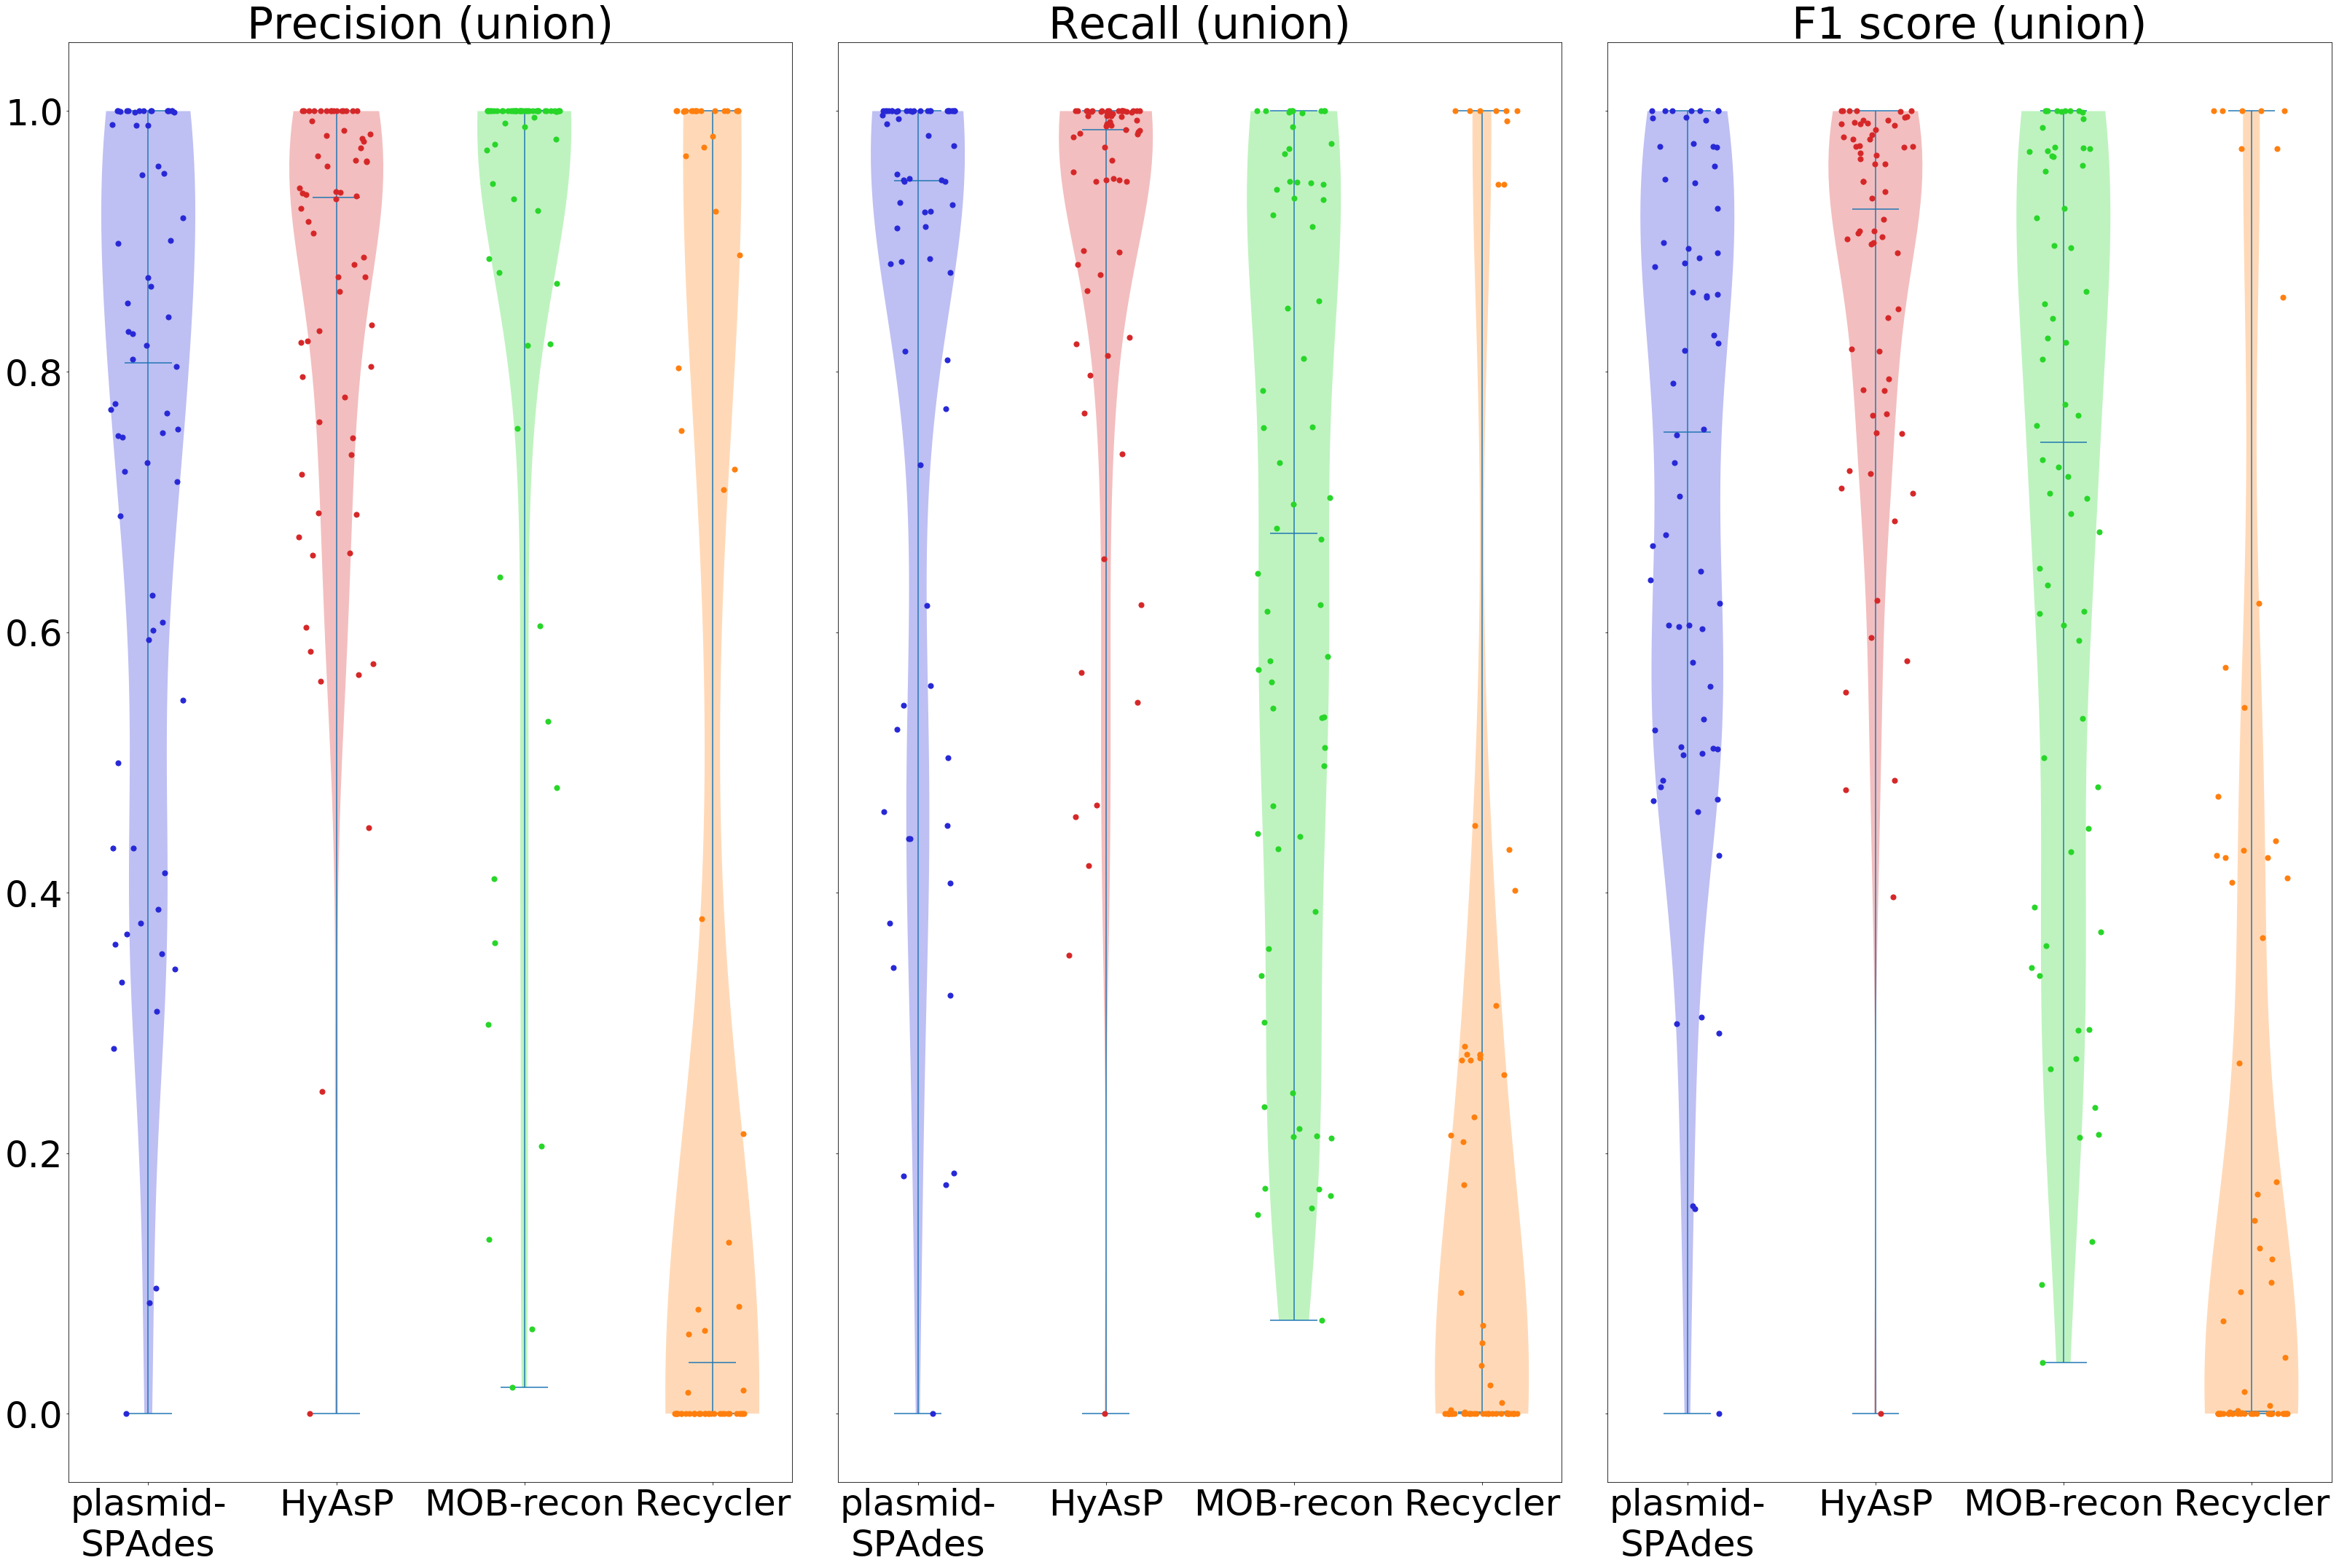

In [12]:
fig, axes = plt.subplots(ncols = 3, figsize = (45, 30), sharey = 'row')

create_subplot(fig, axes, 0, 'Precision (union)', union_precision_values, tool_labels)
create_subplot(fig, axes, 1, 'Recall (union)', union_recall_values, tool_labels)
create_subplot(fig, axes, 2, 'F1 score (union)', union_f1_score_values, tool_labels)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelsize = 50)
    ax.xaxis.set_tick_params(labelsize = 50)
    labels = tool_labels
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(labels)
plt.tight_layout()

plt.savefig('distributions_ncbi_filtered_union.eps', format = 'eps', dpi = 1200)
plt.savefig('distributions_ncbi_filtered_union.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('distributions_ncbi_filtered_union.png', format = 'png', dpi = 1200)

### Statistics for precision, recall and F1 score

Refinement: analyses best and union scores

In [13]:
precision_stats = []
recall_stats = []
f1_stats = []
tool_groups = scores_per_sample.groupby('tool')
for tool, group in tool_groups:
    for e in ['union', 'best']:
        col = group['Precision (%s)' % e]
        precision_stats.append([tool, e, col.min(), col.mean(), col.std(), col.quantile(0.25), 
                                col.quantile(0.5), col.quantile(0.75), col.max()])
    for e in ['union', 'best']:
        col = group['Recall (%s)' % e]
        recall_stats.append([tool, e, col.min(), col.mean(), col.std(), col.quantile(0.25), 
                             col.quantile(0.5), col.quantile(0.75), col.max()])
    for e in ['union', 'best']:
        col = group['F1 score (%s)' % e]
        f1_stats.append([tool, e, col.min(), col.mean(), col.std(), col.quantile(0.25), 
                         col.quantile(0.5), col.quantile(0.75), col.max()])

precision_stats = pd.DataFrame(precision_stats, columns = ['tool', 'evaluation', 'min', 'mean', 'sd', 'q25', 'median', 'q75', 'max'])
recall_stats = pd.DataFrame(recall_stats, columns = ['tool', 'evaluation', 'min', 'mean', 'sd', 'q25', 'median', 'q75', 'max'])
f1_stats = pd.DataFrame(f1_stats, columns = ['tool', 'evaluation', 'min', 'mean', 'sd', 'q25', 'median', 'q75', 'max'])

**Statistics of precision values across test samples**

In [14]:
precision_stats

,tool,evaluation,min,mean,sd,q25,median,q75,max
0,HyAsP,union,0.0000,0.848261,0.192868,0.766245,0.933763,0.984269,1.0
1,HyAsP,best,0.0000,0.818713,0.199759,0.724465,0.874868,0.975279,1.0
2,MOB-recon,union,0.0201,0.870913,0.257858,0.896047,1.000000,1.000000,1.0
3,MOB-recon,best,0.0201,0.868446,0.257385,0.878572,1.000000,1.000000,1.0
4,Recycler,union,0.0000,0.390461,0.462319,0.000000,0.039412,0.995161,1.0
5,Recycler,best,0.0000,0.390461,0.462319,0.000000,0.039411,0.995161,1.0
6,plasmidSPAdes,union,0.0000,0.731891,0.272826,0.559195,0.806760,0.989693,1.0
7,plasmidSPAdes,best,0.0000,0.653426,0.267161,0.434034,0.657670,0.886151,1.0


**Statistics of recall values across test samples**

In [15]:
recall_stats

,tool,evaluation,min,mean,sd,q25,median,q75,max
0,HyAsP,union,0.000000,0.889445,0.197433,0.876266,0.985464,0.999972,1.0
1,HyAsP,best,0.000000,0.670882,0.265819,0.481031,0.666758,0.944808,1.0
2,MOB-recon,union,0.071675,0.648591,0.298650,0.436173,0.675785,0.944612,1.0
3,MOB-recon,best,0.040483,0.560355,0.337560,0.285201,0.536178,0.942977,1.0
4,Recycler,union,0.000000,0.208767,0.335766,0.000000,0.001048,0.274707,1.0
5,Recycler,best,0.000000,0.208199,0.335754,0.000000,0.001047,0.274707,1.0
6,plasmidSPAdes,union,0.000000,0.808190,0.270534,0.647659,0.946650,1.000000,1.0
7,plasmidSPAdes,best,0.000000,0.797933,0.278479,0.574357,0.946650,1.000000,1.0


**Statistics of F1 scores across test samples**

In [16]:
f1_stats

,tool,evaluation,min,mean,sd,q25,median,q75,max
0,HyAsP,union,0.000000,0.854911,0.184220,0.772077,0.925025,0.981172,1.0
1,HyAsP,best,0.000000,0.710693,0.227224,0.594311,0.728702,0.907895,1.0
2,MOB-recon,union,0.039408,0.690134,0.285472,0.457057,0.745663,0.965336,1.0
3,MOB-recon,best,0.039408,0.612682,0.314289,0.381164,0.615333,0.949322,1.0
4,Recycler,union,0.000000,0.222646,0.332616,0.000000,0.001967,0.422935,1.0
5,Recycler,best,0.000000,0.221848,0.332533,0.000000,0.001967,0.422935,1.0
6,plasmidSPAdes,union,0.000000,0.712765,0.248320,0.514948,0.753543,0.940200,1.0
7,plasmidSPAdes,best,0.000000,0.665246,0.241936,0.488914,0.665288,0.857673,1.0


## Total scores per species

In [17]:
contents = []

for org in sorted(samples_per_org.keys()):
    recall_scores = ncbi_references.loc[ncbi_references['sample_id'].isin(samples_per_org[org])]
    precision_scores = ncbi_predictions.loc[ncbi_predictions['sample_id'].isin(samples_per_org[org])]
    
    for tool in recall_scores['tool'].unique():
        best_recalled_nt = 0
        union_recalled_nt = 0
        total_length_refs = 0
        rows = recall_scores.loc[recall_scores['tool'] == tool]
        for i, row in rows.iterrows():
            best_recalled_nt += row['length'] * row['best_recall']
            union_recalled_nt += row['length'] * row['union_recall']
            total_length_refs += row['length']
            
        best_precise_nt = 0
        union_precise_nt = 0
        total_length_preds = 0
        rows = precision_scores.loc[precision_scores['tool'] == tool]
        for i, row in rows.iterrows():
            best_precise_nt += row['length'] * row['best_precision']
            union_precise_nt += row['length'] * row['union_precision']
            total_length_preds += row['length']
            
        best_recall = best_recalled_nt / total_length_refs
        best_precision = (best_precise_nt / total_length_preds) if total_length_preds > 0 else 0
        best_f1 = (2 * best_recall * best_precision / (best_recall + best_precision)) if (best_recall + best_precision) > 0 else 0
        
        union_recall = union_recalled_nt / total_length_refs
        union_precision = (union_precise_nt / total_length_preds) if total_length_preds > 0 else 0
        union_f1 = (2 * union_recall * union_precision / (union_recall + union_precision)) if (union_recall + union_precision) > 0 else 0
            
        contents.append([org, tool, best_recall, union_recall, best_precision, union_precision, best_f1, union_f1])
        
aggregated_scores_per_org = pd.DataFrame(contents, columns = ['Organism', 'Tool', 'Recall (best)', 'Recall (union)', 'Precision (best)', 'Precision (union)', 'F1 score (best)', 'F1 score (union)'])

In [18]:
aggregated_scores_per_org

,Organism,Tool,Recall (best),Recall (union),Precision (best),Precision (union),F1 score (best),F1 score (union)
0,Aeromonas veronii,HyAsP,0.977530,1.000000,0.982160,0.982160,0.979840,0.991000
1,Aeromonas veronii,plasmidSPAdes,0.947975,0.947975,0.594000,0.594000,0.730358,0.730359
2,Aeromonas veronii,Recycler,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Aeromonas veronii,MOB-recon,0.283893,0.497471,0.932738,0.932738,0.435297,0.648870
4,Citrobacter freundii,HyAsP,1.000000,1.000000,0.937452,0.937452,0.967717,0.967717
5,Citrobacter freundii,plasmidSPAdes,1.000000,1.000000,0.989812,0.989811,0.994880,0.994880
6,Citrobacter freundii,Recycler,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Citrobacter freundii,MOB-recon,0.988189,0.988189,1.000000,1.000000,0.994059,0.994059
8,Enterococcus faecium,HyAsP,0.165264,0.536816,0.790363,0.835823,0.273368,0.653752
9,Enterococcus faecium,plasmidSPAdes,0.663125,0.663125,0.371111,0.459723,0.475893,0.543001


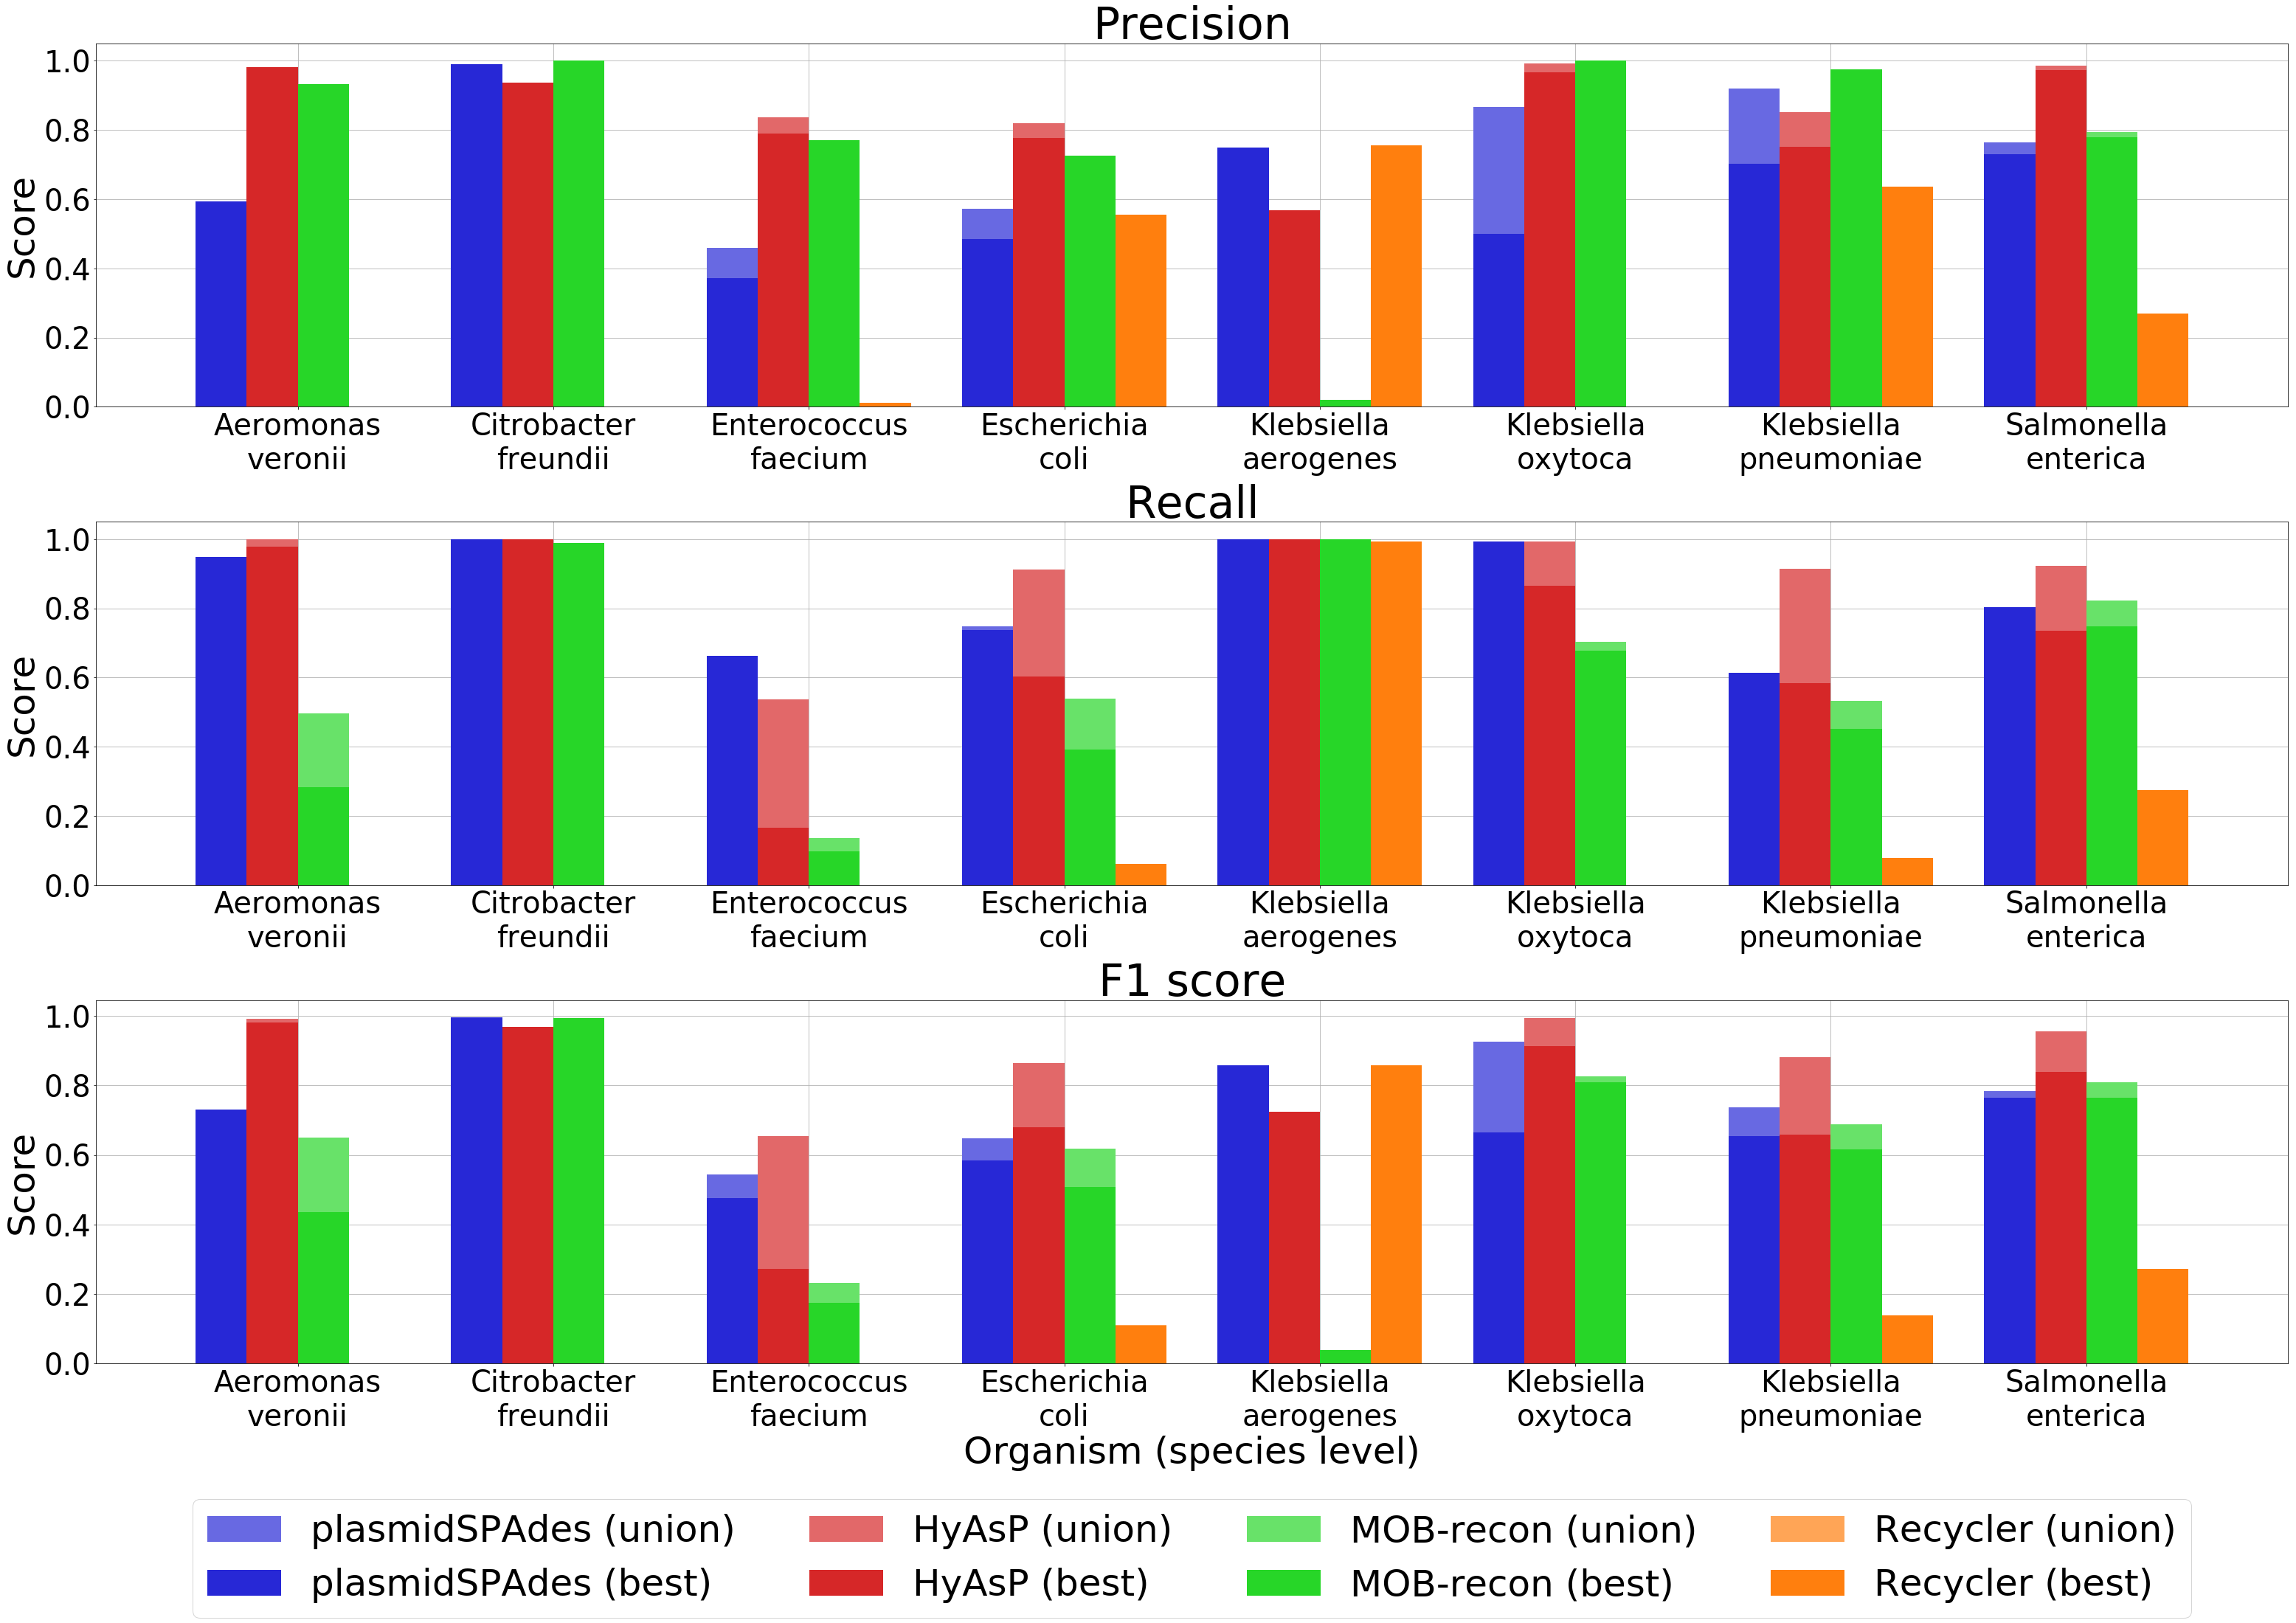

In [19]:
def plot_scores_per_org(df, score_labels, nr = 3, fs = (45, 30)):
    fig, axes = plt.subplots(nrows = nr, figsize = fs)
    # with transparency (alpha = 0.7)
    #alpha = 0.7
    #colours = ['#2728d6', '#d62728', '#27d628', '#ff7f0e']
    # without transparency
    alpha = 1.0
    tools = ['plasmidSPAdes', 'HyAsP', 'MOB-recon', 'Recycler']
    colours = ['#6869e2', '#e26869', '#68e269', '#ffa556', '#2728d6', '#d62728', '#27d628', '#ff7f0e']
    num_orgs = len(df['Organism'].unique())
    pos = list(range(num_orgs))

    i = 0
    for lab in score_labels:
        width = 1 / (len(tools) + 1)
        offset = -len(tools) / 2
        j = 0
        for tool in tools:
            axes[i].bar([p + offset * width for p in pos], df['%s (union)' % lab][df['Tool'] == tool], width = width, 
                        color = colours[j], alpha = alpha, label = '%s (union)' % tool, zorder = 3)
            axes[i].bar([p + offset * width for p in pos], df['%s (best)' % lab][df['Tool'] == tool], width = width, 
                        color = colours[j + len(tools)], alpha = alpha, label = '%s (best)' % tool, zorder = 3)
            j += 1
            offset += 1
        i += 1
    
    plot_labels = ['Precision', 'Recall', 'F1 score']
    for i in range(0, len(score_labels)):
        axes[i].axis('on')
        axes[i].grid(True, zorder = 0)
        axes[i].set_ylabel('Score', fontsize = 50)
        axes[i].set_xticks([p - 0.5 * width for p in pos])
        axes[i].set_xticklabels([s.replace(' ', '\n') for s in df['Organism'].unique()])
        axes[i].xaxis.set_tick_params(labelsize = 40)
        axes[i].yaxis.set_tick_params(labelsize = 40)
        axes[i].set_title(plot_labels[i], fontsize = 60)        
        i += 1

    axes[2].set_xlabel('Organism (species level)', fontsize = 50)
    plt.legend(fontsize = 50, markerscale = 3, ncol = len(tools), loc = 'lower center', bbox_to_anchor = (0.5, -0.75))
    
    plt.subplots_adjust(hspace = 0.4)
    plt.tight_layout()
    
    plt.savefig('per_species_ncbi_filtered.eps', format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('per_species_ncbi_filtered.pdf', format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('per_sample_ncbi_filtered.png', format = 'png', dpi = 1200, bbox_inches = 'tight')
    
plot_scores_per_org(aggregated_scores_per_org, ['Precision', 'Recall', 'F1 score'])